In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer

In [1]:
df = pd.read_csv('tweets_nlp_modelling_v3.csv')
print(df.shape)
df.head()

NameError: name 'pd' is not defined

In [5]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [7]:
seed = 38
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16452,) (4113,) (16452, 3) (4113, 3)


In [8]:
max_features = 20000
tokenizer = TweetTokenizer()
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [9]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(16452, 30) (4113, 30)


In [10]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

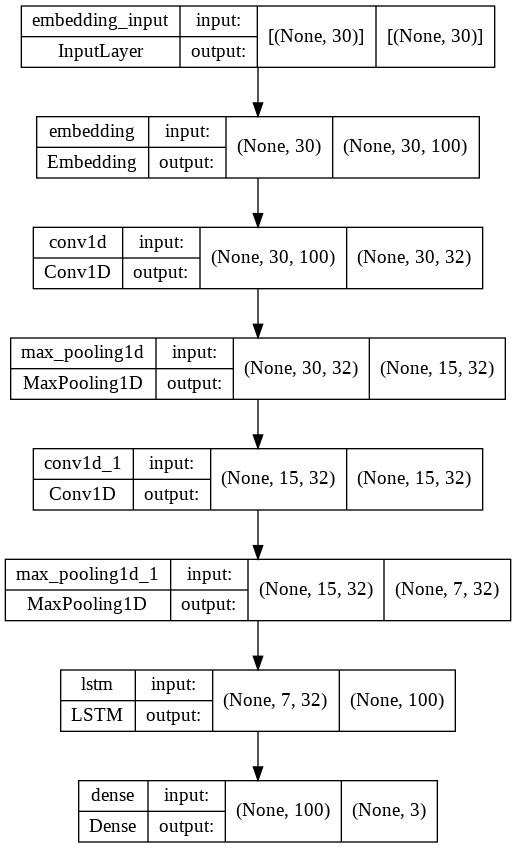

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
129/129 - 12s - loss: 0.7530 - accuracy: 0.6782 - val_loss: 0.4793 - val_accuracy: 0.8140 - 12s/epoch - 92ms/step
Epoch 2/10
129/129 - 7s - loss: 0.2952 - accuracy: 0.8974 - val_loss: 0.3380 - val_accuracy: 0.8726 - 7s/epoch - 56ms/step
Epoch 3/10
129/129 - 8s - loss: 0.1249 - accuracy: 0.9579 - val_loss: 0.3669 - val_accuracy: 0.8714 - 8s/epoch - 59ms/step
Epoch 4/10
129/129 - 10s - loss: 0.0642 - accuracy: 0.9809 - val_loss: 0.4716 - val_accuracy: 0.8794 - 10s/epoch - 76ms/step
Epoch 5/10
129/129 - 9s - loss: 0.0391 - accuracy: 0.9889 - val_loss: 0.5043 - val_accuracy: 0.8724 - 9s/epoch - 73ms/step
Epoch 6/10
129/129 - 9s - loss: 0.0300 - accuracy: 0.9917 - val_loss: 0.5602 - val_accuracy: 0.8670 - 9s/epoch - 68ms/step
Epoch 7/10
129/129 - 7s - loss: 0.0197 - accuracy: 0.9948 - val_loss: 0.6156 - val_accuracy: 0.8697 - 7s/epoch - 57ms/step
Epoch 8/10
129/129 - 7s - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.6472 - val_accuracy: 0.8731 - 7s/epoch - 57ms/step
Epoch 9/10
1

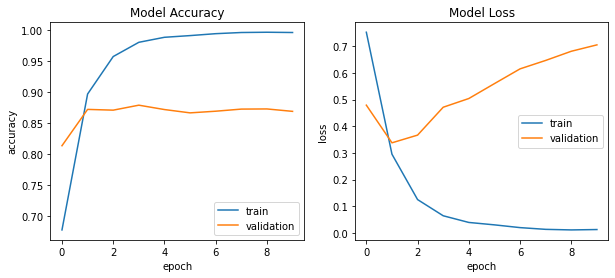

In [15]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [16]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	86.9%
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       449
           1       0.82      0.86      0.84      1435
           2       0.92      0.91      0.91      2229

    accuracy                           0.87      4113
   macro avg       0.84      0.82      0.83      4113
weighted avg       0.87      0.87      0.87      4113



2    2229
1    1435
0     449
dtype: int64
2    2225
1    1501
0     387
dtype: int64


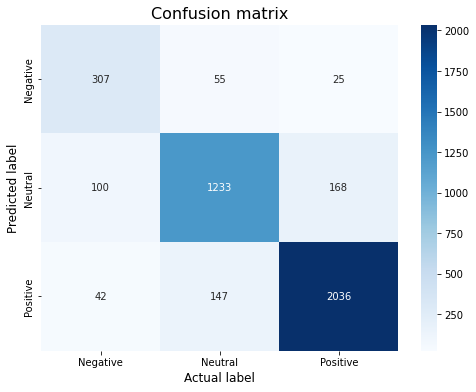

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)